In [1]:
%cd ../..

C:\Users\qaz89\Documents\Git Repos


In [2]:
!cd

C:\Users\qaz89\Documents\Git Repos


In [3]:
import os
import sys
print(sys.version)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]


In [4]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
import torchvision

import pdb
import math
import matplotlib.pyplot as plt
import glob
import PIL
import json

### Build the model

In [5]:
# practice building the model
class SimpleCNN(nn.Module):
    
    def __init__(self, num_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(14*14*32, 128)
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = self.pool1(X)
        X = self.drop1(X)
        X = X.reshape(-1, 14*14*32)
        X = F.relu(self.fc1(X))
        X = self.drop2(X)
        X = self.fc2(X)
        
        return X # logits

### Define helper functions for encoding/decoding segmentation map
<img src="https://github.com/ykchua1/deepLrn/raw/master/images/fig_segmap.PNG" alt="fig" width="200"/>

Inspired by this [webpage](https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)

In [22]:
# import json color palette file
with open('deepLrn/data/scene_parsing/cityscapes_info.json') as f:
    palette_data = json.loads(f.read())
    
label2train = dict(palette_data['label2train'])
labels_txt = palette_data['label']
palette = palette_data['palette']

In [47]:
def full2partial(inp): # converts the 35 class label image into a 19 class segmap array
    inp = np.asarray(inp)
    return np.vectorize(label2train.get)(inp)

def partial2array(inp, nClass=19): # converts partial array to 19 x H x W array
    
    # initialise output array
    out = [np.zeros_like(inp).astype(np.uint8) for i in range(nClass)]
    
    for label in range(nClass):
        idx = inp == label
        out[label][idx] = 1
    
    return np.stack(out)

def segmap2rgb(image, palette=palette): # converts image (segmap) to rgb
    
    nc = len(palette)
    
    # define the class to color mapping
    label_colors = np.array(palette)
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for label in range(0, nc):
        idx = image == label
        r[idx] = label_colors[label, 0]
        g[idx] = label_colors[label, 1]
        b[idx] = label_colors[label, 2]
        
    rgb = np.stack([r, g, b], axis=2)
    return rgb    

### Training label images exploration
* For more information on indexed color images, click [here](https://drububu.com/tutorial/image-types.html)

In [113]:
# show numpy shape of sample given training label image

im = (PIL.Image.open("deepLrn/data/data\GTA_V/train_label/00007.png"))
im_array = np.asarray(im)
print('Shape:', im_array.shape, '\nUnique pixel values:', np.unique(im_array))

Shape: (704, 1280) 
Unique pixel values: [ 0  1  5  7  8 11 12 13 15 17 19 20 21 22 23 24 26 27]


In [21]:
# show numpy shape of sample given val label image

im = (PIL.Image.open("deepLrn/data/data/CItyscapes/val_label/aachen_000008_000019_gtFine_labelIds.png"))
im_array = np.asarray(im)
print('Shape:', im_array.shape, '\nUnique pixel values:', np.unique(im_array))

Shape: (640, 1280) 
Unique pixel values: [ 0  1  3  4  6  7  8 11 12 17 19 20 21 22 23 24 25 26 32]


### Find the mean and std of the training dataset
* Inspired by [this Pytorch discussion](https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/2)
<img src="https://github.com/ykchua1/deepLrn/raw/master/images/fig_finding_mean.PNG" alt="fig" width="400"/>

In [81]:
class MeanStdDataset(torch.utils.data.Dataset):
    def __init__(self, filename_list, im_transform=None, label_transform=None):
        # initialisation
        self.filename_list = filename_list
        self.im_transform = im_transform
        self.label_transform = label_transform

    def __len__(self):
        # denotes the number of samples
        return len(self.filename_list)

    def __getitem__(self, index):
        # generates 1 sample of data
        
        # select sample
        filename = os.path.basename(self.filename_list[index])
        pdb.set_trace

        # load data and get label
        X = PIL.Image.open('deepLrn/data/data/GTA_V/train_img/' + filename)
        Y = PIL.Image.open('deepLrn/data/data/GTA_V/train_label/' + filename)

        if self.im_transform:
            X = self.im_transform(X)
        if self.label_transform:
            Y = self.label_transform(Y)
            Y = full2partial(Y)
            Y = partial2array(Y)
            Y = transforms.functional.to_tensor(Y)

        return X

In [82]:
# define the transforms

crop_height = 512

im_transform = transforms.Compose([
    transforms.Resize(crop_height+8),
    transforms.CenterCrop(crop_height),
    transforms.ToTensor()
])

In [94]:
# Pytorch dataloader class takes in import arguments (params)

params = {'batch_size': 6,
          'shuffle': True,
          'num_workers': 0}

gta_filename_list = sorted(glob.glob('deepLrn/data/data/GTA_V/train_img/*.png'))

gta_training_set = MeanStdDataset(gta_filename_list, im_transform=im_transform)
gta_training_gen = torch.utils.data.DataLoader(gta_training_set, **params)

In [109]:
mean = 0.
std = 0.
i = 0
for X in gta_training_gen:
    mean += X.mean([0,2,3])
    std += X.std([0,2,3])
    
#     if i%10 == 0:
#         print(i)
#     i += 1

mean /= len(gta_training_gen)
std /= len(gta_training_gen)

KeyboardInterrupt: 

In [105]:
mean, std

(tensor([0.4791, 0.4759, 0.4649]), tensor([0.2539, 0.2502, 0.2493]))

### Unnormalizing callable class
* Inspired by [this](https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821)

In [110]:
tr_img_mean = (0.4791, 0.4759, 0.4649) 
tr_img_std = (0.2539, 0.2502, 0.2493) 

In [111]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [115]:
im = (PIL.Image.open("deepLrn/data/data/GTA_V/train_img/00007.png"))
im_array = np.asarray(im)

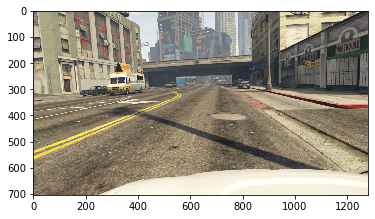

In [126]:
# testing the code
unNorm = UnNormalize(tr_img_mean, tr_img_std)
x = transforms.functional.normalize(transforms.functional.to_tensor(im_array), tr_img_mean, tr_img_std)
x = unNorm(x)
plt.imshow(x.numpy().transpose(1,2,0))